In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from nbvis import plotNb

In [2]:
df = pd.read_csv("NotebookCategoryInfo.csv",index_col=0)

### Use Levenshtein distance to compute a similarity matrix

In [3]:
import distance
sent1 = ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
sent2 = ['the', 'lazy', 'fox', 'jumps', 'over', 'the', 'crazy', 'dog']
distance.levenshtein(sent1, sent2)

3

In [4]:
tseries1 = list(df[df["name"]=="nb_348235"].category)

In [5]:
tseries2 = list(df[df["name"]=="nb_1063377"].category)

In [6]:
distance.levenshtein(tseries1, tseries2)

603

In [7]:
all_nbs=df.name.unique()
# using a subset of 100 notebooks to cluster for now, we can add the full set later, the similarity matrix takes a while to compute
subset_nbs = all_nbs[:100]

In [8]:
import numpy as np

In [9]:
# Compute Similarity Matrix
simMat = []
for nb1 in subset_nbs:
    sim_nb1 = []
    for nb2 in subset_nbs:
        tseries1 = list(df[df["name"]==nb1].category)
        tseries2 = list(df[df["name"]==nb2].category)
        dist = distance.levenshtein(tseries1, tseries2)
        sim_nb1.append(dist)
    simMat.append(sim_nb1)

In [10]:
simMatrix = np.array(simMat)

In [11]:
np.shape(simMatrix)

(100, 100)

In [12]:
clustering = AgglomerativeClustering(n_clusters=3).fit(simMatrix)

/Users/jerrysong/miniconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [13]:
clustering.labels_

array([0, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 1,
       2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 0, 0, 2, 0, 1, 2, 2,
       0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0])

### Visualizing the notebooks in each cluster and printing some descriptive stats

In [14]:
nbIdx = np.where(clustering.labels_==0)[0]

clustNb = list(subset_nbs[nbIdx])
clustDf = df[df["name"].isin(clustNb)]
# clustDf.groupby(["name","category"])["line"].mean().groupby("category").mean().sort_values(ascending=False)

print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])


Top 5 most common categories based on average occurence of categories in cluster category
join      21.904110
stats     18.923077
other     18.835079
plot      14.079545
create    13.048193
Name: line, dtype: float64
Average number of lines of each series in cluster 267.75
Average number of cells of each series in cluster 30.5625


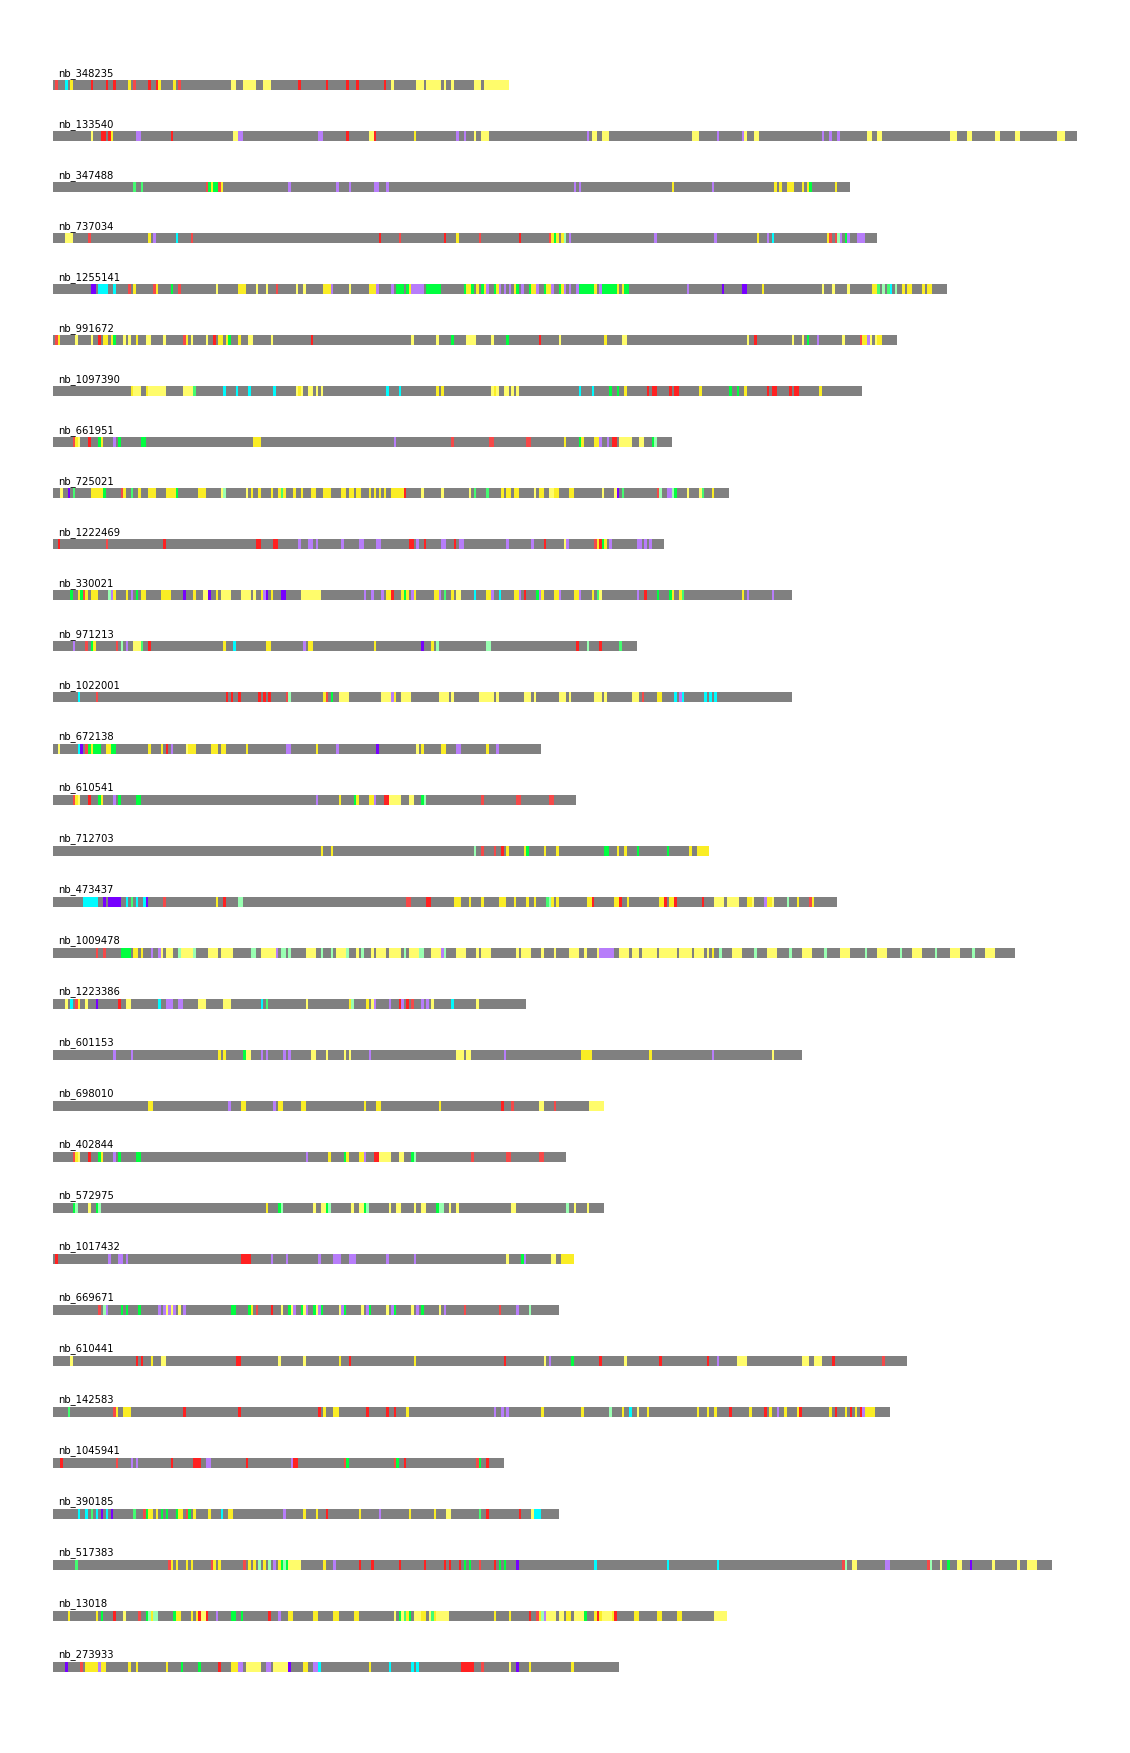

In [15]:
plotNb(df,list(subset_nbs[nbIdx]))

In [16]:
nbIdx = np.where(clustering.labels_==1)[0]
clustNb = list(subset_nbs[nbIdx])
clustDf = df[df["name"].isin(clustNb)]
print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])


Top 5 most common categories based on average occurence of categories in cluster category
join        36.307018
stats       34.008197
plot        25.445122
other       22.978102
cleaning    19.304348
Name: line, dtype: float64
Average number of lines of each series in cluster 580.0
Average number of cells of each series in cluster 31.88888888888889


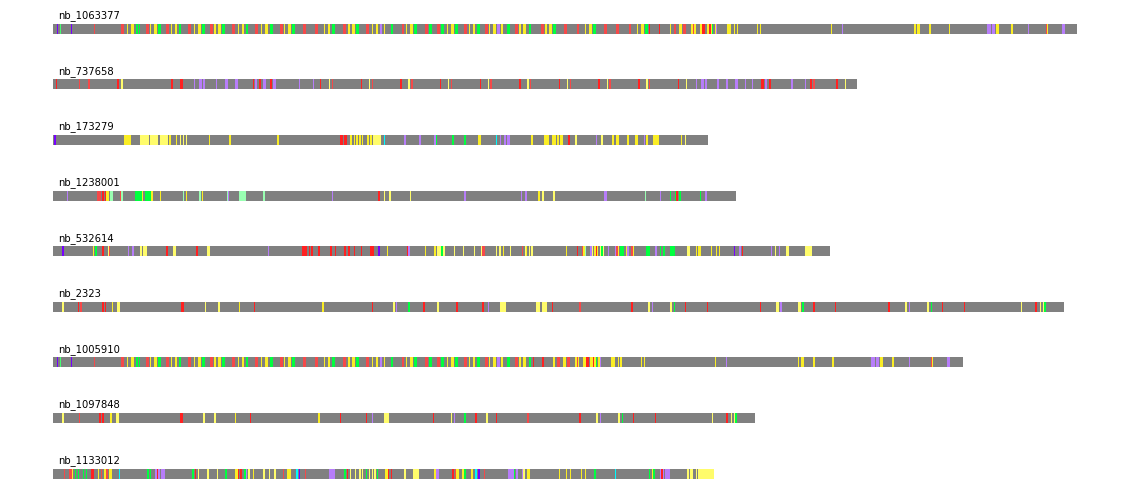

In [17]:
plotNb(df,list(subset_nbs[nbIdx]))

In [18]:
nbIdx = np.where(clustering.labels_==2)[0]
clustNb = list(subset_nbs[nbIdx])
clustDf = df[df["name"].isin(clustNb)]
print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])


Top 5 most common categories based on average occurence of categories in cluster category
join              8.297872
postprocessing    6.863636
other             5.935432
stats             5.838298
cleaning          5.520930
Name: line, dtype: float64
Average number of lines of each series in cluster 99.79661016949153
Average number of cells of each series in cluster 24.271186440677965


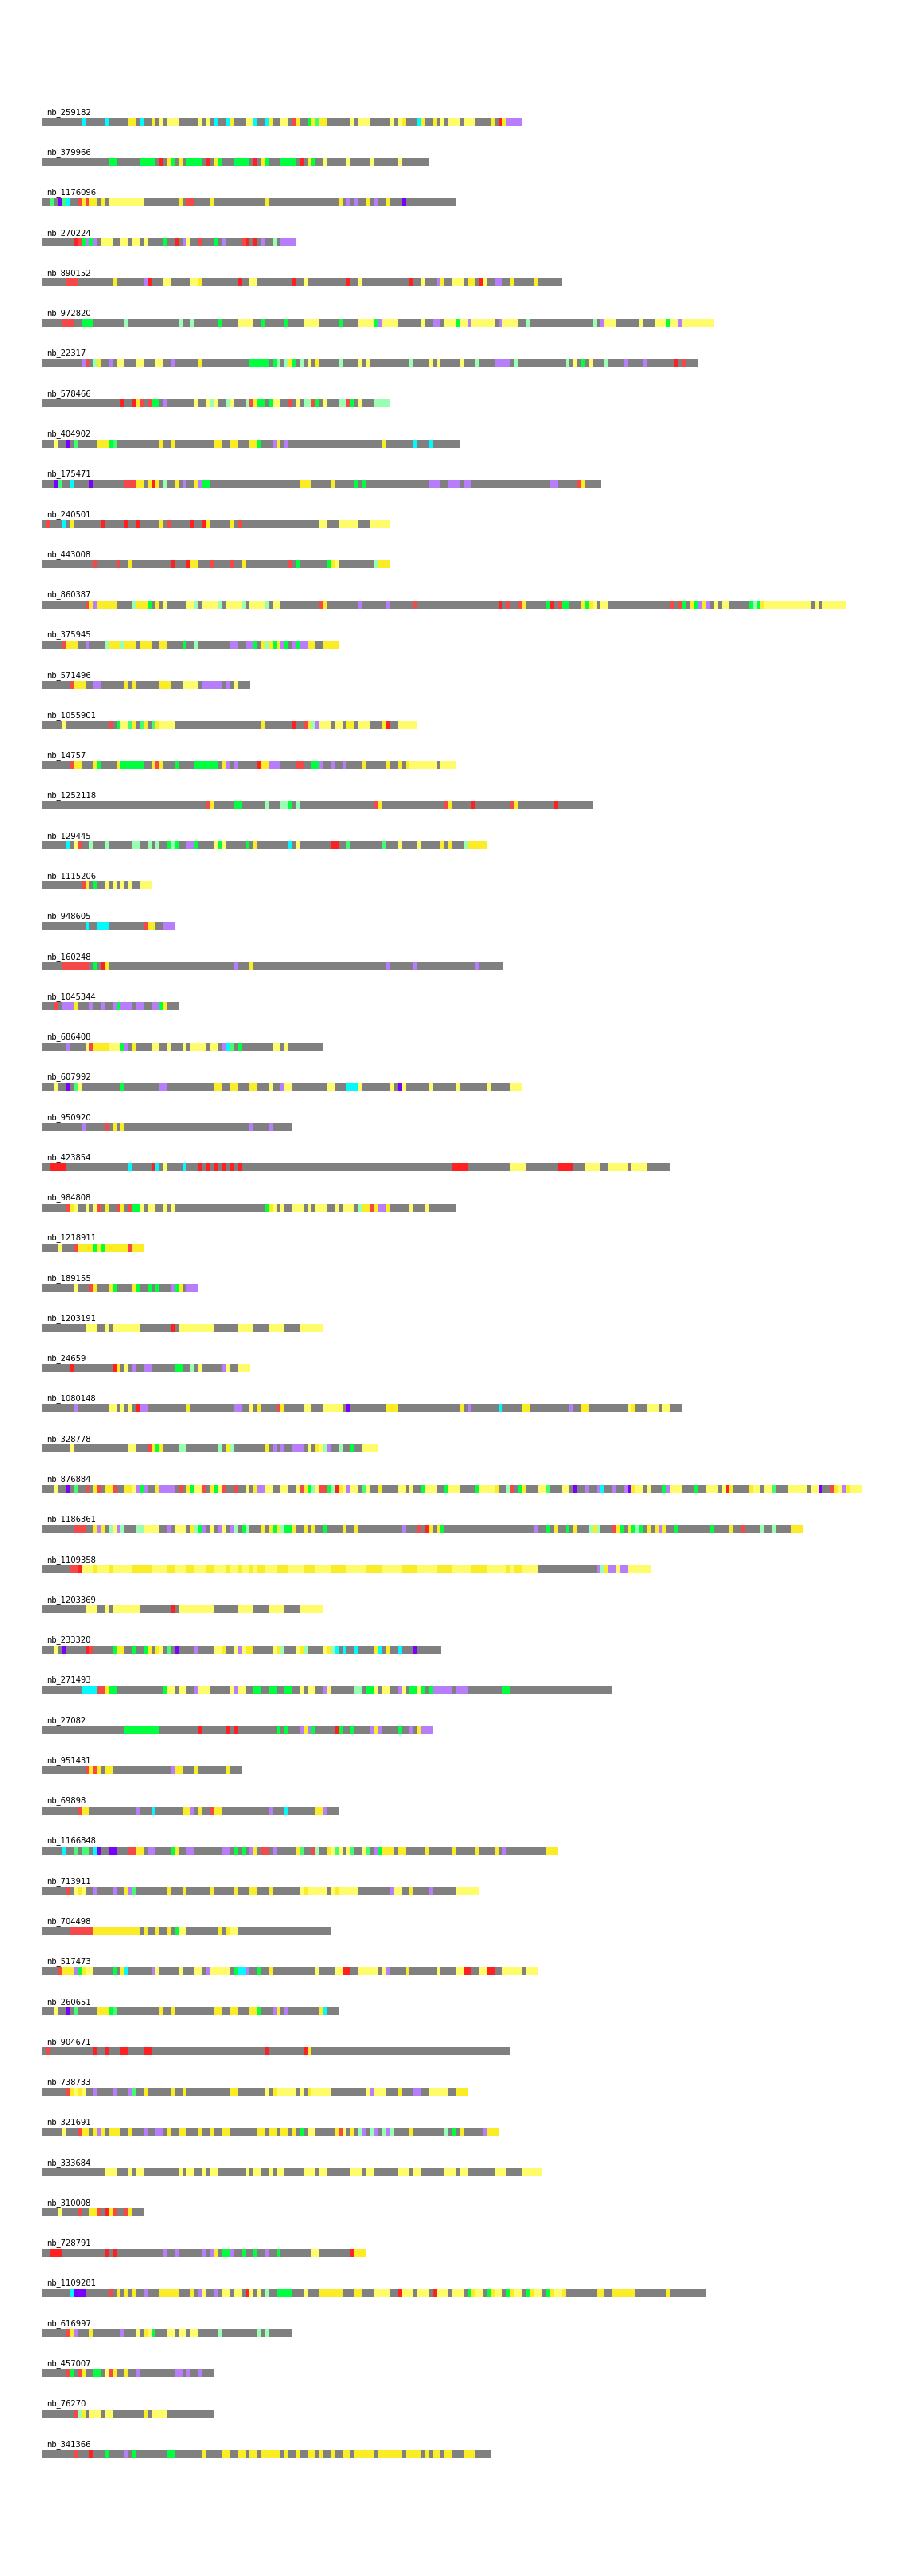

In [19]:
plotNb(df,list(subset_nbs[nbIdx]))

Looks like cluster 1 and 2 is more interspersed and cluster 3 has more longer chunks. But that just might be because the number of code line in each cluster is quite different. We should try playing around with the number of variables.

## Normalized Length Notebooks

In [20]:
mat = []
for nbName in df.name.unique():
    categoryList = list(df[df['name']==nbName]['category'])
    mat += [categoryList]

In [21]:
maxSize = 5000
def reScale(lst):
    factor = int(round(maxSize / len(lst)))
    lenDiff = factor * len(lst) - maxSize
    error = lenDiff / maxSize
    newLst = []
    for item in lst:
        newLst += [item] * factor
    for i in range(abs(lenDiff)):
        if lenDiff > 0:
            newLst.remove('other')
        else:
            newLst.append('other')
        
    return newLst, factor, error
        

In [22]:
reshaped = []
factors = []
errors = []
for lst in mat:
    newLst, factor, error = reScale(lst)
    reshaped.append(newLst)
    factors.append(factor)
    errors.append(error)

In [23]:
# Compute Similarity Matrix
normalizedSimMat = []
for nb1 in reshaped[:2]:
    sim_nb1 = []
    for nb2 in reshaped[:2]:
        dist = distance.levenshtein(nb1, nb2)
        sim_nb1.append(dist)
    normalizedSimMat.append(sim_nb1)

In [24]:
normalizedSimMat

[[0, 2298], [2298, 0]]

## Extracting Features by Estimating Transition Probabilities

In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from nbvis import plotNb
df = pd.read_csv("NotebookCategoryInfo.csv",index_col=0)

In [19]:
all_nbs=df.name.unique()

In [20]:
mat = []
for nbName in df.name.unique():
    categoryList = list(df[df['name']==nbName]['category'])
    mat += [categoryList]

In [21]:
indexMap = {}
i = 0
for category in set(df['category']):
    indexMap[category] = i
    i += 1
len(indexMap.keys())

11

In [22]:
# taken from https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
def transitionMatrix(transitions):
    n = len(indexMap.keys()) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[indexMap[i]][indexMap[j]] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)  

In [23]:
featureMatrix = []
for lst in mat:
    featureMatrix.append(transitionMatrix(lst).flatten())
    # Add Features here (eg length, flattened transition matrix between macro categories, etc.)

In [24]:
np.array(featureMatrix)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.46511628],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.        ,
        0.5       ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
# Compute Similarity Matrix
featurizedSimMat = []
for nb1 in featureMatrix:
    sim_nb1 = []
    for nb2 in featureMatrix:
        dist = scipy.spatial.distance.euclidean(nb1,nb2)
        if dist == 0:
            sim_nb1.append(dist)
        else:
            sim_nb1.append(1/dist)
    featurizedSimMat.append(sim_nb1)

featurizedSimMat = np.array(featurizedSimMat)

In [29]:
clustering = AgglomerativeClustering(n_clusters=4).fit(featurizedSimMat)

/Users/dorislee/.virtualenvs/jpy/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [30]:
len(clustering.labels_)

587

In [31]:
labels = pd.Series(clustering.labels_,name="Cluster")

In [32]:
labels.value_counts()

0    582
2      3
3      1
1      1
Name: Cluster, dtype: int64

In [33]:
# nbIdx = np.where(clustering.labels_==0)[0]
# clustNb = list(all_nbs[nbIdx])
# clustDf = df[df["name"].isin(clustNb)]
# plotNb(df,list(all_nbs[nbIdx]))

Top 5 most common categories based on average occurence of categories in cluster category
stats       13.000000
plot        10.800000
other       10.088095
join         8.750000
cleaning     6.785714
Name: line, dtype: float64
Average number of lines of each series in cluster 479.0
Average number of cells of each series in cluster 51.0


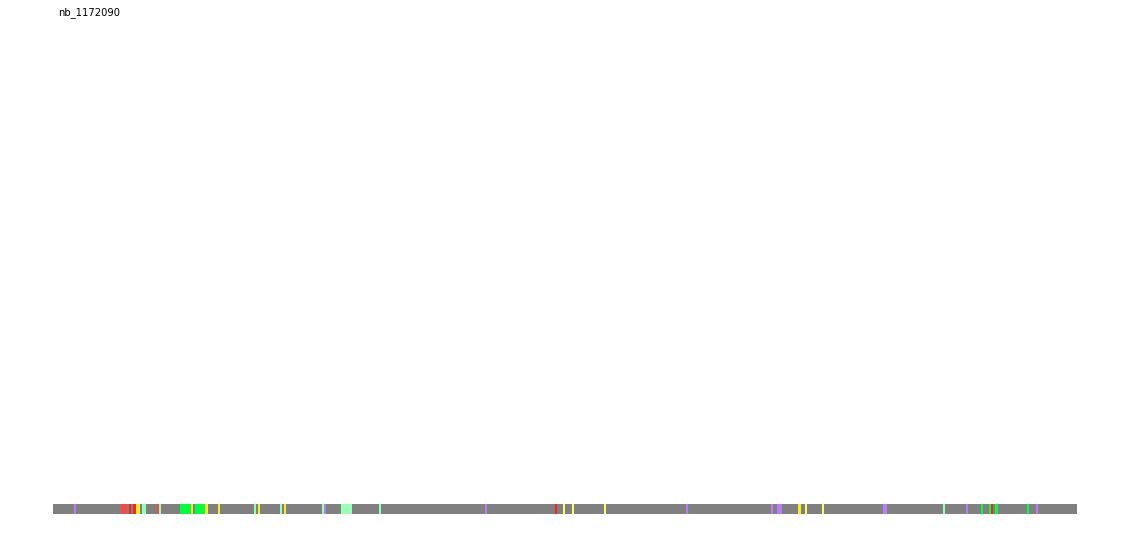

In [34]:
nbIdx = np.where(clustering.labels_==1)[0]
clustNb = list(all_nbs[nbIdx])
clustDf = df[df["name"].isin(clustNb)]
plotNb(df,list(all_nbs[nbIdx]))
print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])

Top 5 most common categories based on average occurence of categories in cluster category
stats       13.000000
plot        10.800000
other       10.014320
join         8.750000
cleaning     6.785714
Name: line, dtype: float64
Average number of lines of each series in cluster 478.0
Average number of cells of each series in cluster 44.333333333333336


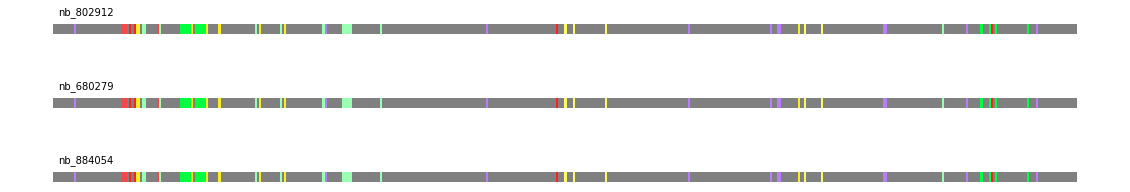

In [35]:
nbIdx = np.where(clustering.labels_==2)[0]
clustNb = list(all_nbs[nbIdx])
clustDf = df[df["name"].isin(clustNb)]
plotNb(df,list(all_nbs[nbIdx]))
print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])

Top 5 most common categories based on average occurence of categories in cluster category
print    19.666667
plot     12.750000
other    12.128378
stats    11.444444
group     9.230769
Name: line, dtype: float64
Average number of lines of each series in cluster 498.0
Average number of cells of each series in cluster 37.0


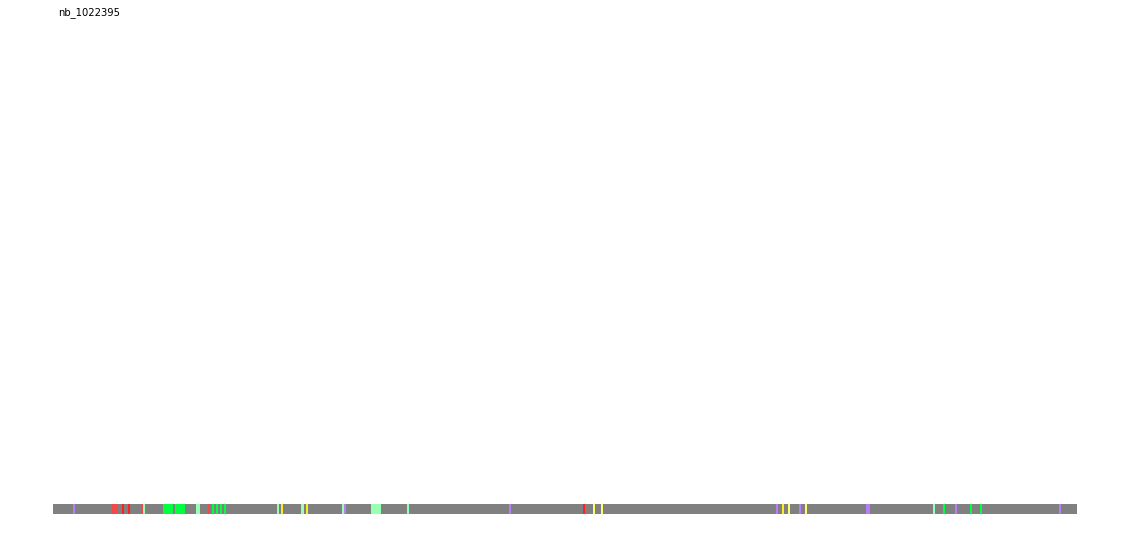

In [36]:
nbIdx = np.where(clustering.labels_==3)[0]
clustNb = list(all_nbs[nbIdx])
clustDf = df[df["name"].isin(clustNb)]
plotNb(df,list(all_nbs[nbIdx]))
print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])

In [37]:
clustering = AgglomerativeClustering(n_clusters=10).fit(featurizedSimMat)
labels = pd.Series(clustering.labels_,name="Cluster")
labels.value_counts()

/Users/dorislee/.virtualenvs/jpy/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


1    570
5      3
2      3
0      3
6      2
3      2
9      1
8      1
7      1
4      1
Name: Cluster, dtype: int64

Top 5 most common categories based on average occurence of categories in cluster category
create    32.000000
other     21.772277
join      19.666667
print     13.000000
group     11.000000
Name: line, dtype: float64
Average number of lines of each series in cluster 201.33333333333334
Average number of cells of each series in cluster 13.333333333333334


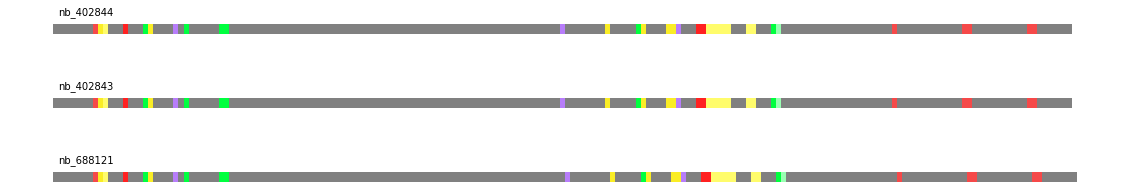

In [40]:
nbIdx = np.where(clustering.labels_==0)[0]
clustNb = list(all_nbs[nbIdx])
clustDf = df[df["name"].isin(clustNb)]
plotNb(df,list(all_nbs[nbIdx]))
print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])

Top 5 most common categories based on average occurence of categories in cluster category
cleaning    57.333333
plot        45.235294
stats       40.333333
other       25.211329
join        22.066667
Name: line, dtype: float64
Average number of lines of each series in cluster 340.0
Average number of cells of each series in cluster 16.666666666666668


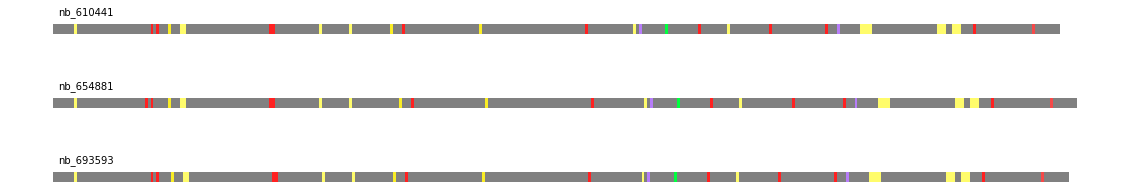

In [39]:
nbIdx = np.where(clustering.labels_==2)[0]
clustNb = list(all_nbs[nbIdx])
clustDf = df[df["name"].isin(clustNb)]
plotNb(df,list(all_nbs[nbIdx]))
print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])

There are a lot of identical or highly similar notebooks.

/Users/dorislee/.virtualenvs/jpy/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


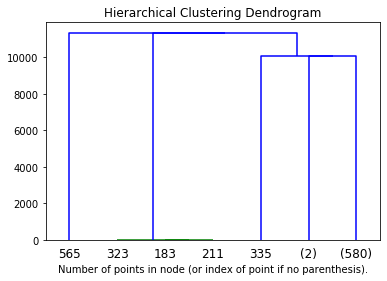

In [48]:
# Code based on : https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(featurizedSimMat)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.ylim(0,20)
plt.show()

In [63]:
import scipy
import seaborn as sns

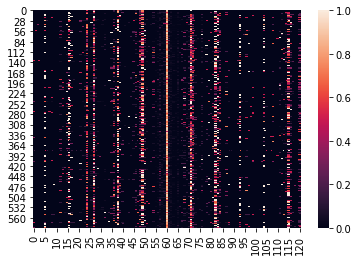

In [64]:
sns.heatmap(featureMatrix)

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(featureMatrix)

In [66]:
np.shape(featureMatrix)

(587, 121)

In [69]:
clustering = AgglomerativeClustering(n_clusters=4).fit(featureMatrix)
labels = pd.Series(clustering.labels_,name="Cluster")
labels.value_counts()

0    226
2    155
1    130
3     76
Name: Cluster, dtype: int64

In [73]:
def visualize_clusters(df, labels, clusterID, Nsample=5):
    nbIdx = np.where(labels==clusterID)[0]
    nbIdx = nbIdx[:Nsample]
    clustNb = list(all_nbs[nbIdx])
    clustDf = df[df["name"].isin(clustNb)]
    plotNb(df,list(all_nbs[nbIdx]))
    # print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
    # print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
    # print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])

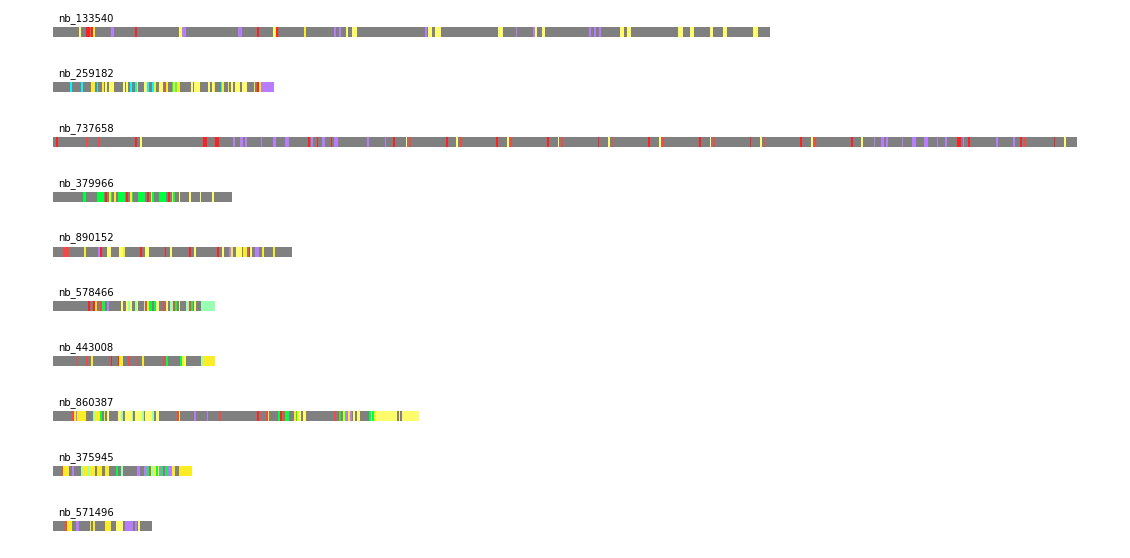

In [77]:
visualize_clusters(df,clustering.labels_, 0, Nsample=10)

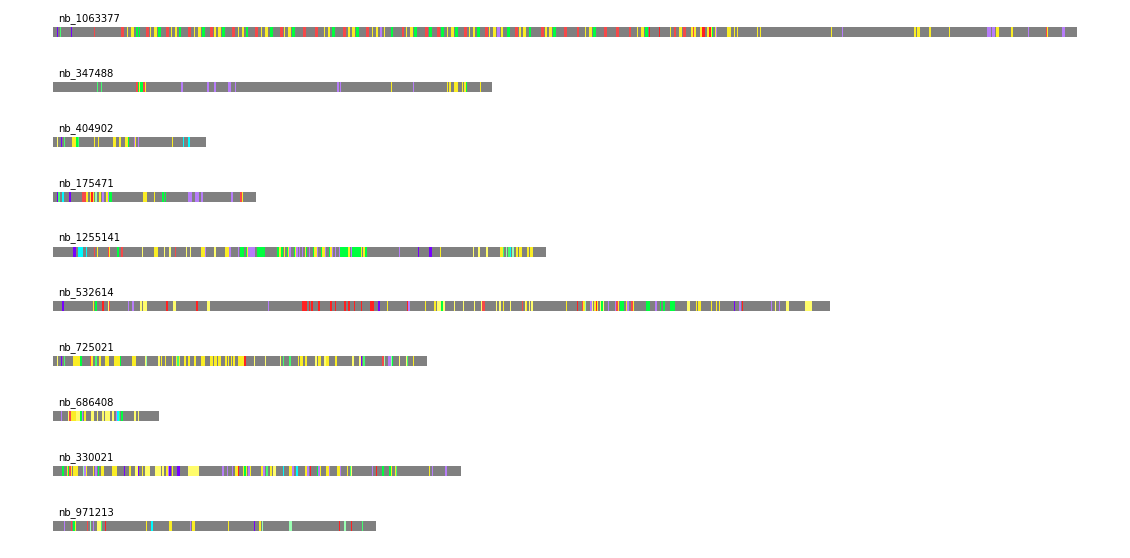

In [78]:
visualize_clusters(df,clustering.labels_, 1, Nsample=10)

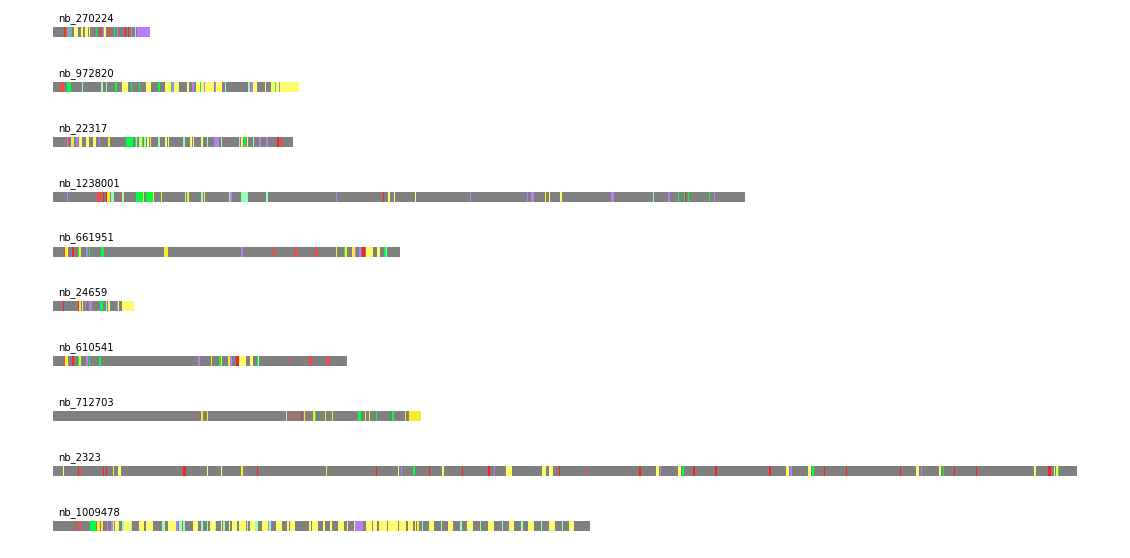

In [76]:
visualize_clusters(df,clustering.labels_, 2, Nsample=10)

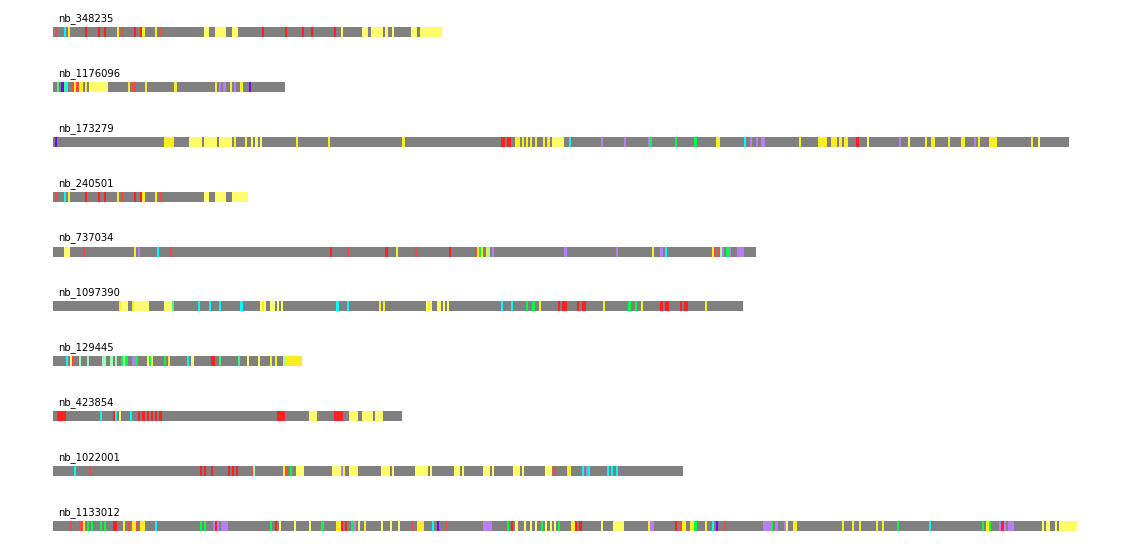

In [79]:
visualize_clusters(df,clustering.labels_, 3, Nsample=10)

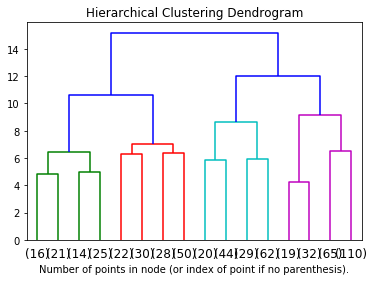

In [72]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(featureMatrix)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

figure out if we should standardize (normalize) or no

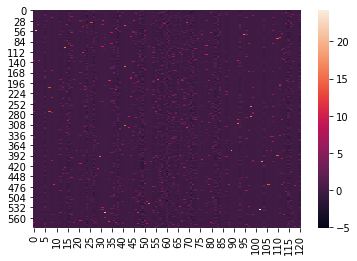

In [68]:
sns.heatmap(X_std)

In [62]:
clustering = AgglomerativeClustering(n_clusters=4).fit(X_std)
labels = pd.Series(clustering.labels_,name="Cluster")
labels.value_counts()

0    432
1    150
2      3
3      2
Name: Cluster, dtype: int64